In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import cv2

In [0]:
count = 0

In [0]:
def FrameCapture(path): 
    global count
    vidObj = cv2.VideoCapture(path) 
    count = 0
    success = 1
  
    while success: 
        success, image = vidObj.read() 
        cv2.imwrite("/content/drive/My Drive/Video_Style_Transfer/video_frames/frame%d.jpg" % count, image) 
        count += 1
    print(count)

In [0]:
FrameCapture("/content/drive/My Drive/Video_Style_Transfer/ocean.mp4")

515


In [0]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import tensorflow as tf
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

Using TensorFlow backend.


In [0]:
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]


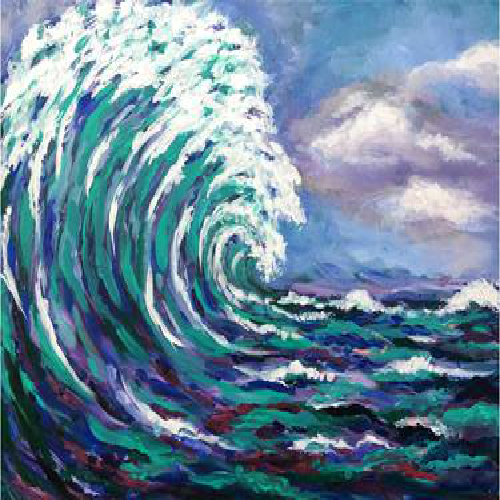

In [0]:
sample_image_path = "https://images.saatchiart.com/saatchi/951100/art/3677343/2747228-XPQWPOTV-6.jpg"
style_image_path = "style.png"
style_image_global = Image.open(BytesIO(requests.get(sample_image_path).content))
style_image_global = style_image_global.resize((500, 500))
style_image_global.save(style_image_path)
style_image_global

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))
  
def gram_matrix(x):
  features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
  gram = backend.dot(features, backend.transpose(features))
  return gram

def compute_style_loss(style, combination):
  style = gram_matrix(style)
  combination = gram_matrix(combination)
  size = 500 * 500
  return backend.sum(backend.square(style - combination)) / (4. * (3 ** 2) * (size ** 2)) # 3 is no. of channels

def total_variation_loss(x):
  a = backend.square(x[:, :499, :499, :] - x[:, 1:, :499, :])
  b = backend.square(x[:, :499, :499, :] - x[:, :499, 1:, :])
  return backend.sum(backend.pow(a + b, 1.25))  # TOTAL_VARIATION_LOSS_FACTOR = 1.25



combination_image = backend.placeholder((1, 500, 500, 3))


In [0]:
def image_stylize(path, path1, count):
  input_image = Image.open(path)
  input_image = input_image.resize((500, 500))
  
  input_image_array = np.asarray(input_image, dtype="float32")
  input_image_array = np.expand_dims(input_image_array, axis=0)
  input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
  input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
  input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
  input_image_array = input_image_array[:, :, :, ::-1]
  
  style_image_array = np.asarray(style_image_global, dtype="float32")
  style_image_array = np.expand_dims(style_image_array, axis=0)
  style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
  style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
  style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
  style_image_array = style_image_array[:, :, :, ::-1]
  
  input_image = backend.variable(input_image_array)
  style_image = backend.variable(style_image_array)
  combination_image = backend.placeholder((1, 500, 500, 3))
  class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients
      
  def evaluate_loss_and_gradients(x):
    x = x.reshape((1, 500, 500, 3))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients
  
  input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
  model = VGG16(input_tensor=input_tensor, include_top=False)
  
  layers = dict([(layer.name, layer.output) for layer in model.layers])

  content_layer = "block2_conv2"
  layer_features = layers[content_layer]
  content_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]

  loss = backend.variable(0.)
  loss += 0.02 * content_loss(content_image_features, combination_features)
 
  style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
  for layer_name in style_layers:
      layer_features = layers[layer_name]
      style_features = layer_features[1, :, :, :]
      combination_features = layer_features[2, :, :, :]
      style_loss = compute_style_loss(style_features, combination_features)
      loss += (4.5 / len(style_layers)) * style_loss

  loss += 0.995 * total_variation_loss(combination_image) # TOTAL_VARIATION_WEIGHT = 0.995
  
  outputs = [loss]
  outputs += backend.gradients(loss, combination_image)

  evaluator = Evaluator()
  x = np.random.uniform(0, 255, (1, 500, 500, 3)) - 128.

  for i in range(10):
      x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
#       print("Iteration %d completed with loss %d" % (i, loss))
  x = x.reshape((500, 500, 3))
  x = x[:, :, ::-1]
  x[:, :, 0] = np.add(x[:, :, 0], IMAGENET_MEAN_RGB_VALUES[2], out=x[:, :, 0], casting="unsafe")
  x[:, :, 1] = np.add(x[:, :, 1], IMAGENET_MEAN_RGB_VALUES[1], out=x[:, :, 1], casting="unsafe")
  x[:, :, 2] = np.add(x[:, :, 2], IMAGENET_MEAN_RGB_VALUES[0], out=x[:, :, 2], casting="unsafe")
  x = np.clip(x, 0, 255).astype("uint8")
  output_image = Image.fromarray(x)
  output_image.save(path1)
  print("Style transfer of frame no. "+str(count)+" is over.")


In [0]:
for i in range(94,count):
  input_frame_path = "/content/drive/My Drive/Video_Style_Transfer/video_frames/frame%d.jpg" % i
  output_frame_path = "/content/drive/My Drive/Video_Style_Transfer/output_video_frames/frame%d.jpg" % i
  image_stylize(input_frame_path, output_frame_path, i)
print("Framewise style transfer done")




58892288/58889256 [==============================] - 5s 0us/step


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Style transfer of frame no. 94 is over.
Style transfer of frame no. 95 is over.
Style transfer of frame no. 96 is over.
Style transfer of frame no. 97 is over.
Style transfer of frame no. 98 is over.
Style transfer of frame no. 99 is over.
Style transfer of frame no. 100 is over.
Style transfer of frame no. 101 is over.
Style transfer of frame no. 102 is over.
Style transfer of frame no. 103 is over.
Style transfer of frame no. 104 is over.
Style transfer of frame no. 105 is over.
Style transfer of frame no. 106 is over.


FileNotFoundError: ignored

In [0]:
count = 515